![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Use watsonx, and `meta-llama/llama-3-1-8b` to Fine Tune with LoRA on online banking queries annotated

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.


## Notebook content

This notebook contains the steps and code to demonstrate support of LoRA Fine Tuning in watsonx.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goal

The goal of this notebook is to demonstrate how to:
- upload of dataset with prompts
- trigger fine tuning process
- review of fine tuning process details
- deploy fine-tuned model
- inference of fine-tuned model
- compare with base model


## Contents

This notebook contains the following parts:

- [Setup](#setup)
- [Data loading](#data_loading)
- [Initialize experiment](#initialize)
- [Run Fine Tuning](#run_tuning)
- [Fine Tuning details](#run_details)
- [Store Base Model](#store_base_fm)
- [Deploy Base Model](#deploy_base)
- [Deploy Tuned Model](#deploy)
- [Preparing data for testing process](#test_data)
- [Foundation Models Inference on `watsonx.ai`](#models_inference)
- [Comparison of prediction results](#comparison)
- [Clean up](#cleanup)
- [Summary and next steps](#summary)


<a id="setup"></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>).

### Install dependecies

In [ ]:
!pip install wget | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install "scikit-learn==1.3" | tail -n 1

### Define the watsonx.ai credentials
Use the code cell below to define the watsonx.ai credentials that are required to work with watsonx Foundation Models.

**Action:** Provide the IBM Cloud user API key. For details, see <a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank" rel="noopener no referrer">Managing user API keys</a>.

In [ ]:
import getpass
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    url="https://us-south.ml.cloud.ibm.com",
    api_key=getpass.getpass("Enter your watsonx.ai api key and hit enter: "),
)

### Define the project ID
The Foundation Model requires project id that provides the context for the call. We will obtain the id from the project in which this notebook runs. Otherwise, please provide the project id.

In [3]:
import os

try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = input("Please enter your project_id (hit enter): ")

### API Client initialization

Create an instance of APIClient with authentication details.

In [4]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials=credentials, project_id=project_id)

<a id="data_loading"></a>
## Preparing data for Fine Tuning training process

This example uses the <a href="https://huggingface.co/datasets/PolyAI/banking77" target="_blank" rel="noopener no referrer">Banking77</a> training dataset with 200 samples. 

In [ ]:
import os
import wget
import json
import pandas as pd
from pathlib import Path

filename = "train.csv"
base_url = "https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/"

path = Path(os.getcwd()) / filename
if path.exists():
    path.unlink()
wget.download(f"{base_url}{filename}")

banking_df = pd.read_csv("train.csv").sample(n=200, random_state=42)

data = [
    {"input": row["text"], "output": row["category"]}
    for _, row in banking_df.iterrows()
]

ft_training_data = "ft_training_data.json"
with open(ft_training_data, "w", encoding="utf-8") as json_file:
    json.dump(data, json_file, indent=4, ensure_ascii=False)

To create a data asset for your project, execute the cell below. The asset will be utilized in the Fine-Tuning training process.

In [ ]:
asset_details = client.data_assets.create(
    name=ft_training_data, file_path=ft_training_data
)
asset_id = client.data_assets.get_id(asset_details)

Creating data asset...
SUCCESS


Define connection information to training data.

In [7]:
from ibm_watsonx_ai.helpers import DataConnection
from ibm_watsonx_ai.helpers.connections.base_connection import BaseConnection

data_conn = DataConnection(data_asset_id=asset_id, connection=BaseConnection())

<a id="initialize"></a>
## Initialize Fine Tuning experiment 

In [8]:
from ibm_watsonx_ai.experiment import TuneExperiment

experiment = TuneExperiment(credentials, project_id=project_id)

To display all available foundation models with lora fine tuning support, execute the cell below.

In [ ]:
[
    model["model_id"]
    for model in client.foundation_models.get_model_specs_with_lora_fine_tuning_support().get(
        "resources"
    )
]

['ibm/granite-3-1-8b-base', 'meta-llama/llama-3-1-8b']

Define `fine_tuner` parameters with set `peft_parameters`.

In [ ]:
from ibm_watsonx_ai.foundation_models.schema import PeftParameters

peft_parameters = PeftParameters(
    type="lora",
    rank=32,
    lora_alpha=64,
)

fine_tuner = experiment.fine_tuner(
    name="IBM watsonx.ai SDK - Fine Tune with LoRA",
    description="IBM watsonx.ai SDK - Fine Tune with LoRA",
    base_model="meta-llama/llama-3-1-8b",
    task_id="classification",
    num_epochs=5,
    learning_rate=5e-05,
    batch_size=2,
    accumulate_steps=4,
    verbalizer="### Instruction:\nClassify the text into one of the following categories: activate my card, age limit, apple pay or google pay, atm support, automatic top up, balance not updated after bank transfer, balance not updated after cheque or cash deposit, beneficiary not allowed, cancel transfer, card about to expire, card acceptance, card arrival, card delivery estimate, card linking, card not working, card payment fee charged, card payment not recognised, card payment wrong exchange rate, card swallowed, cash withdrawal charge, cash withdrawal not recognised, change pin, compromised card, contactless not working, country support, declined card payment, declined cash withdrawal, declined transfer, direct debit payment not recognised, disposable card limits, edit personal details, exchange charge, exchange rate, exchange via app, extra charge on statement, failed transfer, fiat currency support, get disposable virtual card, get physical card, getting spare card, getting virtual card, lost or stolen card, lost or stolen phone, order physical card, passcode forgotten, pending card payment, pending cash withdrawal, pending top up, pending transfer, pin blocked, receiving money, Refund not showing up, request refund, reverted card payment?, supported cards and currencies, terminate account, top up by bank transfer charge, top up by card charge, top up by cash or cheque, top up failed, top up limits, top up reverted, topping up by card, transaction charged twice, transfer fee charged, transfer into account, transfer not received by recipient, transfer timing, unable to verify identity, verify my identity, verify source of funds, verify top up, virtual card not working, visa or mastercard, why verify identity, wrong amount of cash received, wrong exchange rate for cash withdrawal\n\n### Input:\n{{input}}\n\n### Response:\n{{output}}",
    response_template="\n### Response:\n",
    auto_update_model=True,
    gpu={"num": 1},
    peft_parameters=peft_parameters,
)

You can review previous set parameters with `get_params()` method.

In [11]:
fine_tuner.get_params()

{'base_model': {'model_id': 'meta-llama/llama-3-1-8b'},
 'task_id': 'classification',
 'num_epochs': 5,
 'learning_rate': 5e-05,
 'batch_size': 2,
 'accumulate_steps': 4,
 'verbalizer': '### Instruction:\nClassify the text into one of the following categories: activate my card, age limit, apple pay or google pay, atm support, automatic top up, balance not updated after bank transfer, balance not updated after cheque or cash deposit, beneficiary not allowed, cancel transfer, card about to expire, card acceptance, card arrival, card delivery estimate, card linking, card not working, card payment fee charged, card payment not recognised, card payment wrong exchange rate, card swallowed, cash withdrawal charge, cash withdrawal not recognised, change pin, compromised card, contactless not working, country support, declined card payment, declined cash withdrawal, declined transfer, direct debit payment not recognised, disposable card limits, edit personal details, exchange charge, exchange r

<a id="run_tuning"></a>
## Run Fine Tuning


Run a fine tuning process of foundation model on top of the training data referenced by DataConnection (tuning may take some time).


By changing the `background_mode` parameter to `True`, the fine tuning process will run in the background.

In [ ]:
tuning_details = fine_tuner.run(
    training_data_references=[data_conn], background_mode=False
)



##############################################

Running 'f5fb545e-7384-49ba-aec5-dc74b9d4d1c6'

##############################################


pending......................
running...............................................................
completed
Training of 'f5fb545e-7384-49ba-aec5-dc74b9d4d1c6' finished successfully.


<a id="run_details"></a>
## LoRA Fine Tuning details


Check the status/state of the initialized LoRA Fine-Tuning run if it was run in background mode, or when the process finishes if background mode is off.

In [13]:
fine_tuner.get_run_status()

'completed'

Get fine tuning run details.

In [14]:
fine_tuner.get_run_details()

{'entity': {'auto_update_model': True,
  'parameters': {'accumulate_steps': 4,
   'base_model': {'model_id': 'meta-llama/llama-3-1-8b'},
   'batch_size': 2,
   'gpu': {'num': 1},
   'gradient_checkpointing': True,
   'learning_rate': 5e-05,
   'max_seq_length': 1024,
   'num_epochs': 5,
   'peft_parameters': {'lora_alpha': 64,
    'lora_dropout': 0.05,
    'rank': 32,
    'target_modules': [],
    'type': 'lora'},
   'response_template': '\n### Response:\n',
   'task_id': 'classification',
   'verbalizer': '### Instruction:\nClassify the text into one of the following categories: activate my card, age limit, apple pay or google pay, atm support, automatic top up, balance not updated after bank transfer, balance not updated after cheque or cash deposit, beneficiary not allowed, cancel transfer, card about to expire, card acceptance, card arrival, card delivery estimate, card linking, card not working, card payment fee charged, card payment not recognised, card payment wrong exchange rat

Alternatively you can use `get_run_details()` method with metrics.

```python
fine_tuner.get_run_details(include_metrics=True)
```

Let's summarize the run.

In [15]:
fine_tuner.summary()

,Enhancements,Base model,Auto store,Epochs,loss
Model Name,,,,,
model_f5fb545e-7384-49ba-aec5-dc74b9d4d1c6,[fine tuning],meta-llama/llama-3-1-8b,True,5,0.1159


Plot the learning curves to visualize the loss function.

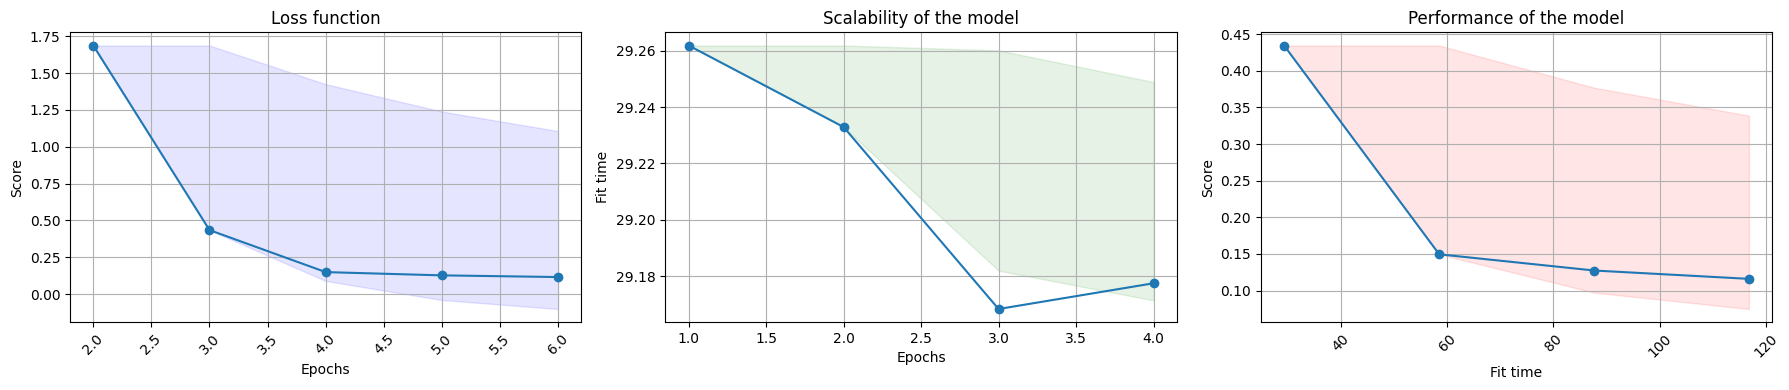

In [16]:
fine_tuner.plot_learning_curve()

You can specify `tuned_model_id` from tuning details.

In [ ]:
tuned_model_id = None

if "id" in tuning_details.get("entity", {}).get("tuned_model", {}):
    tuned_model_id = tuning_details["entity"]["tuned_model"]["id"]
tuned_model_id

'0d652caa-c20a-44b0-bf40-95af8974e7f3'

<a id="store_base_fm"></a>
## Create the "Base Foundation Model Asset"

To display all available base foundation models deployable, execute the cell below.

In [ ]:
[
    model["model_id"]
    for model in client.foundation_models.get_base_foundation_model_deployable_specs().get(
        "resources"
    )
]

['ibm/granite-3-1-8b-base', 'meta-llama/llama-3-1-8b']

In [ ]:
sw_spec_id = client.software_specifications.get_id_by_name("watsonx-cfm-caikit-1.1")

metadata = {
    client.repository.ModelMetaNames.NAME: "Base FT model",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_ID: sw_spec_id,
    client.repository.ModelMetaNames.TYPE: "base_foundation_model_1.0",
}

In [ ]:
stored_base_model_details = client.repository.store_model(
    model="meta-llama/llama-3-1-8b", meta_props=metadata
)

In [21]:
stored_base_model_asset_id = client.repository.get_model_id(stored_base_model_details)
stored_base_model_asset_id

'ad8b4d82-eb7a-4b27-abed-ef09520deba6'

<a id="deploy_base"></a>
## Create the Deployment of "Base Foundation Model" using the "Base Foundation Model Asset"

In [ ]:
from datetime import datetime

meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "FT DEPLOYMENT SDK - project Lora",
    client.deployments.ConfigurationMetaNames.ONLINE: {
        "parameters": {
            "foundation_model": {
                "enable_lora": True,
            },
        },
    },
    client.deployments.ConfigurationMetaNames.SERVING_NAME: f"ft_sdk_deployment_{datetime.now().strftime('%Y_%m_%d_%H%M%S')}",
}

base_model_deployment_details = client.deployments.create(
    stored_base_model_asset_id, meta_props
)



######################################################################################

Synchronous deployment creation for id: 'ad8b4d82-eb7a-4b27-abed-ef09520deba6' started

######################################################################################


initializing...............................
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='57df0c69-b0fb-4ce3-a3a1-f032a5c7fb6f'
-----------------------------------------------------------------------------------------------




You can specify `base_model_deployment_id` from deployment details.

In [ ]:
base_model_deployment_id = base_model_deployment_details["metadata"]["id"]
base_model_deployment_id

'57df0c69-b0fb-4ce3-a3a1-f032a5c7fb6f'

<a id="deploy"></a>
## Create the "LoRA/QLoRA deployment" by providing the "LoRA/QLoRA base model asset" and "Base Foundation Model Deployment ID"

In [ ]:
from datetime import datetime

meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "LORA ADAPTER DEPLOYMENT SDK",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.SERVING_NAME: f"lora_deployment_{datetime.now().strftime('%Y_%m_%d_%H%M%S')}",
    client.deployments.ConfigurationMetaNames.BASE_DEPLOYMENT_ID: base_model_deployment_id,
}

lora_adapter_deployment_details = client.deployments.create(tuned_model_id, meta_props)



######################################################################################

Synchronous deployment creation for id: '0d652caa-c20a-44b0-bf40-95af8974e7f3' started

######################################################################################


initializing.......................
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='4240f805-7ced-4c67-a477-188bb60d6dd3'
-----------------------------------------------------------------------------------------------




You can specify `lora_adapter_deployment_id` from deployment details.

In [ ]:
lora_adapter_deployment_id = lora_adapter_deployment_details["metadata"]["id"]
lora_adapter_deployment_id

'4240f805-7ced-4c67-a477-188bb60d6dd3'

<a id="test_data"></a>
## Preparing data for testing process

This example uses the <a href="https://huggingface.co/datasets/PolyAI/banking77" target="_blank" rel="noopener no referrer">Banking77</a> testing dataset with 200 samples. 

In [ ]:
filename = "test.csv"

path = Path(os.getcwd()) / filename
if path.exists():
    path.unlink()
wget.download(f"{base_url}{filename}")

banking_test_df = pd.read_csv("train.csv").sample(n=200, random_state=42)

The instruction will be utilized in the prompt provided to the Base Model to guide it toward generating the correct response.

In [27]:
instruction = "Instruction:\nClassify the text into one of the following categories: activate my card, age limit, apple pay or google pay, atm support, automatic top up, balance not updated after bank transfer, balance not updated after cheque or cash deposit, beneficiary not allowed, cancel transfer, card about to expire, card acceptance, card arrival, card delivery estimate, card linking, card not working, card payment fee charged, card payment not recognised, card payment wrong exchange rate, card swallowed, cash withdrawal charge, cash withdrawal not recognised, change pin, compromised card, contactless not working, country support, declined card payment, declined cash withdrawal, declined transfer, direct debit payment not recognised, disposable card limits, edit personal details, exchange charge, exchange rate, exchange via app, extra charge on statement, failed transfer, fiat currency support, get disposable virtual card, get physical card, getting spare card, getting virtual card, lost or stolen card, lost or stolen phone, order physical card, passcode forgotten, pending card payment, pending cash withdrawal, pending top up, pending transfer, pin blocked, receiving money, Refund not showing up, request refund, reverted card payment?, supported cards and currencies, terminate account, top up by bank transfer charge, top up by card charge, top up by cash or cheque, top up failed, top up limits, top up reverted, topping up by card, transaction charged twice, transfer fee charged, transfer into account, transfer not received by recipient, transfer timing, unable to verify identity, verify my identity, verify source of funds, verify top up, virtual card not working, visa or mastercard, why verify identity, wrong amount of cash received, wrong exchange rate for cash withdrawal\n\n"

In [28]:
prompts_batch = list(banking_test_df.text)
prompts_batch_with_instruction = [instruction + prompt for prompt in prompts_batch]
predictions = list(banking_test_df.category)

<a id="models_inference"></a>
## Foundation Models Inference on `watsonx.ai`

Provide a set of model parameters.

In [29]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

generate_params = {
    GenParams.MAX_NEW_TOKENS: 256,
}

Initialize the `ModelInference` class with `lora_adapter_deployment_id`.

In [ ]:
from ibm_watsonx_ai.foundation_models import ModelInference

lora_adapter_model = ModelInference(
    deployment_id=lora_adapter_deployment_id, api_client=client, params=generate_params
)

Get deployment model inference details.

In [33]:
lora_adapter_model.get_details()

{'entity': {'asset': {'id': '0d652caa-c20a-44b0-bf40-95af8974e7f3'},
            'base_deployment_id': '57df0c69-b0fb-4ce3-a3a1-f032a5c7fb6f',
            'base_model_id': 'meta-llama/llama-3-1-8b',
            'chat_enabled': False,
            'custom': {},
            'deployed_asset_type': 'lora_adapter',
            'name': 'LORA ADAPTER DEPLOYMENT SDK',
            'online': {'parameters': {'serving_name': 'lora_deployment_2025_06_05_113649'}},
            'project_id': 'eac8bfe2-a00b-43ca-846b-305af5cc6395',
            'status': {'inference': [{'url': 'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/lora_deployment_2025_06_05_113649/text/generation',
                                      'uses_serving_name': True},
                                     {'sse': True,
                                      'url': 'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/lora_deployment_2025_06_05_113649/text/generation_stream',
                                      'uses_serving_nam

### Calculate the accuracy of tuned model

In [34]:
lora_adapter_model_results = lora_adapter_model.generate_text(prompt=prompts_batch)

In [ ]:
from sklearn.metrics import accuracy_score

lora_adapter_model_accuracy_score = accuracy_score(
    predictions, lora_adapter_model_results
)

print(f"accuracy_score: {lora_adapter_model_accuracy_score}")

accuracy_score: 0.625


### Calculate the accuracy of base model

Initialize the `ModelInference` class with `base_model_deployment_id`.

In [ ]:
base_model = ModelInference(
    deployment_id=base_model_deployment_id, params=generate_params, api_client=client
)

In [37]:
base_model_results = base_model.generate_text(prompt=prompts_batch_with_instruction)

In [ ]:
from sklearn.metrics import accuracy_score

base_model_accuracy_score = accuracy_score(predictions, base_model_results)

print(f"accuracy_score: {base_model_accuracy_score}")

accuracy_score: 0.0


<a id="comparison"></a>
## Comparison of prediction results

In [39]:
from tabulate import tabulate

data = [
    ["Accuracy Score", base_model_accuracy_score, lora_adapter_model_accuracy_score],
]

headers = ["Metric", "Base Model", "Tuned Model"]

print(tabulate(data, headers=headers, tablefmt="grid"))

+----------------+--------------+---------------+
| Metric         |   Base Model |   Tuned Model |
+================+==============+===============+
| Accuracy Score |            0 |         0.625 |
+----------------+--------------+---------------+


<a id="cleanup"></a>
## Clean up

To delete the current fine tuning experiment, use the `cancel_run` method.

**Warning:** Be careful: once you delete an experiment, you will no longer be able to refer to it.

In [40]:
fine_tuner.cancel_run(hard_delete=True)

To delete the deployment, use the `delete` method. 

**Warning:** Keeping the deployment active may lead to unnecessary consumption of Compute Unit Hours (CUHs).

In [41]:
client.deployments.delete(lora_adapter_deployment_id)

'SUCCESS'

In [42]:
client.deployments.delete(base_model_deployment_id)

'SUCCESS'

<a id="summary"></a>
## Summary and next steps

You successfully completed this notebook!

You learned how to use fine tuning in watsonx with online banking queries annotated.
 
Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors:
 **Mateusz Szewczyk**, Software Engineer at IBM watsonx.ai.
 
 **Karol Zmorski**, Software Engineer at IBM watsonx.ai.

Copyright © 2025 IBM. This notebook and its source code are released under the terms of the MIT License.